In [ ]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

In [ ]:
# Standard library imports
from os.path import join
from collections import OrderedDict
from array import array

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from collections import defaultdict
import random

# Type hinting imports
from typing import Callable, Dict, List, Optional, Tuple, Any  # For type annotations

# Google Colab specific imports
from google.colab import drive
drive.mount('/content/drive')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import torchvision
import torchvision.transforms as transforms

# torchvision imports
import torchvision.transforms as transforms  # For image transformations

# Flower (Federated Learning) imports
import flwr as fl  # Core Flower framework
from flwr.common import (  # Common Flower types and functions
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    Context,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager  # For managing clients on server-side
from flwr.server.client_proxy import ClientProxy  # For server-side client proxy management

# Device setup
DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training on cpu using PyTorch 2.3.1+cu121 and Flower 1.10.0


# Load Data

In [ ]:
batch_size = 32

## CIFAR 10

In [ ]:
cifar10_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=cifar10_transform)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

cifar10_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=cifar10_transform)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Generate balanced data and unbalanced data

In [ ]:
def split_dataset_balanced(num_clients, train_dataset, test_dataset, batch_size=32):
    """
    Splits the given training and testing data into balanced subsets for a given number of clients
    and returns lists of DataLoader objects.
    """
    # Create datasets
    # train_dataset = CustomDataset(X_train, y_train)
    # test_dataset = CustomDataset(X_test, y_test)

    def create_balanced_subsets(dataset, num_clients):

        # Group indices by label
        label_to_indices = defaultdict(list)
        for idx in range(len(dataset)):
                _, label = dataset[idx]
                label_to_indices[label].append(idx)

        # Find the minimum number of samples for any label
        min_label_count = min(len(indices) for indices in label_to_indices.values())

        # Determine the number of samples per client per label
        samples_per_client_per_label = min_label_count // num_clients

        # Create an array to hold indices for each client
        client_indices = [[] for _ in range(num_clients)]

        # Distribute indices for each label to each client
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)  # Shuffle indices to ensure randomness
            for i in range(num_clients):
                start_idx = i * samples_per_client_per_label
                end_idx = (i + 1) * samples_per_client_per_label
                client_indices[i].extend(indices[start_idx:end_idx])

        # Create subsets for each client
        subsets = [Subset(dataset, indices) for indices in client_indices]

        return subsets

    # Create balanced subsets for train and test datasets
    train_subsets = create_balanced_subsets(train_dataset, num_clients)
    test_subsets = create_balanced_subsets(test_dataset, num_clients)

    # Create DataLoaders for each subset
    train_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in train_subsets]
    test_loaders = [DataLoader(subset, batch_size=batch_size, shuffle=False) for subset in test_subsets]

    return train_loaders, test_loaders

def create_unbalanced_loaders(train_loaders, test_loaders, label_counts, alpha):
    """
    Converts balanced train and test DataLoader objects into unbalanced DataLoader objects by redistributing the samples.

    """

    def create_unbalanced_loader(loader, p):
        label_to_indices = defaultdict(list)
        dataset = loader.dataset

        # Build the mapping from labels to indices
        for idx in range(len(dataset)):
            _, label = dataset[idx]
            label_to_indices[label].append(idx)

        subset_indices = []
        for label, indices_list in label_to_indices.items():
            prob = p[label]
            for idx in indices_list:
                if np.random.rand() < prob:
                    subset_indices.append(idx)

        subset_dataset = Subset(dataset, subset_indices)
        subset_loader = DataLoader(subset_dataset, batch_size=loader.batch_size, shuffle=True)

        return subset_loader

    unbalanced_train_loaders = []
    unbalanced_test_loaders = []
    for i in range(len(train_loaders)):

        train_loader = train_loaders[i]
        test_loader = test_loaders[i]

        # Generate Dirichlet distribution to get probabilities
        p = np.random.dirichlet([alpha] * label_counts)

        # Normalize probabilities
        p /= np.max(p)

        unbalanced_train_loaders.append(create_unbalanced_loader(train_loader, p))
        unbalanced_test_loaders.append(create_unbalanced_loader(test_loader, p))

    return unbalanced_train_loaders, unbalanced_test_loaders

# Plot label distribution

In [ ]:
def get_labels_from_subset(subset):
    labels = []
    for _, label in subset:
        labels.append(label)
    return labels

def plot_label_distribution(train_loaders):
    client_number = len(train_loaders)
    row = math.ceil(client_number / 5)
    fig, axs = plt.subplots(row, 5, figsize=(10, row * 2))  # Adjusted figsize for better visibility
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    for i, data_loader in enumerate(train_loaders):
        client_dataset = data_loader.dataset
        labels = get_labels_from_subset(client_dataset)
        label_counts = np.bincount(labels)
        # print(label_counts)

        ax = axs[i]
        cmap = plt.cm.YlGnBu  # Choose colormap
        colors = cmap(np.linspace(0.1, 0.9, len(label_counts)))  # Generate colors
        ax.bar(range(len(label_counts)), label_counts, color=colors)
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        ax.set_title(f'Client {i + 1}')

    # Hide any unused subplots
    for j in range(len(train_loaders), len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

# CNN

In [ ]:
def train(net, trainloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    for _ in range(epochs):
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return loss, accuracy

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Client

In [ ]:
class Client(fl.client.NumPyClient):
    def __init__(self, net, train_loader, test_loader, num_examples):
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.net = net
        self.num_examples = num_examples

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.train_loader, epochs=4)
        _, accuracy = test(self.net, self.test_loader)
        return self.get_parameters(config={}), self.num_examples["trainset"], {"accuracy": accuracy}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.test_loader)
        return float(loss), self.num_examples["testset"], {"accuracy": float(accuracy)}

def get_client_fn(train_loaders, test_loaders, num_examples):
    """Return a function to construct a client.

    """

    def client_fn(context: Context) -> Client:
        # print(f"context: {context}")
        cid = context.node_config["partition-id"]

        train_loader = train_loaders[int(cid)]
        test_loader = test_loaders[int(cid)]
        net = Net().to(DEVICE)

        # print(f"cid: {int(cid)}")

        return Client(net, train_loader, test_loader, num_examples).to_client()

    return client_fn

# Strategy

# Start Simulation

In [ ]:

NUM_CLIENTS = 20
ROUND = 50

def get_evaluate_server_fn(model, test_loader):
    def evaluate_fn(server_round, parameters, config):
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        loss, accuracy = test(model, test_loader)
        return loss, {"accuracy": accuracy}
    return evaluate_fn

def start_simulation(train_loaders, test_loaders, strategy):
    train_set_length = sum(len(loader.dataset) for loader in train_loaders)
    test_set_length = sum(len(loader.dataset) for loader in test_loaders)
    num_examples = {"trainset": train_set_length, "testset": test_set_length}

    # Start simulation
    fl.simulation.start_simulation(
        client_fn=get_client_fn(train_loaders, test_loaders, num_examples),
        num_clients=NUM_CLIENTS,
        config=fl.server.ServerConfig(num_rounds=ROUND),
        strategy=strategy
    )


    # strategy.plot_accuracies()
    # strategy.print_accuracy_matrix()

In [ ]:
import pickle

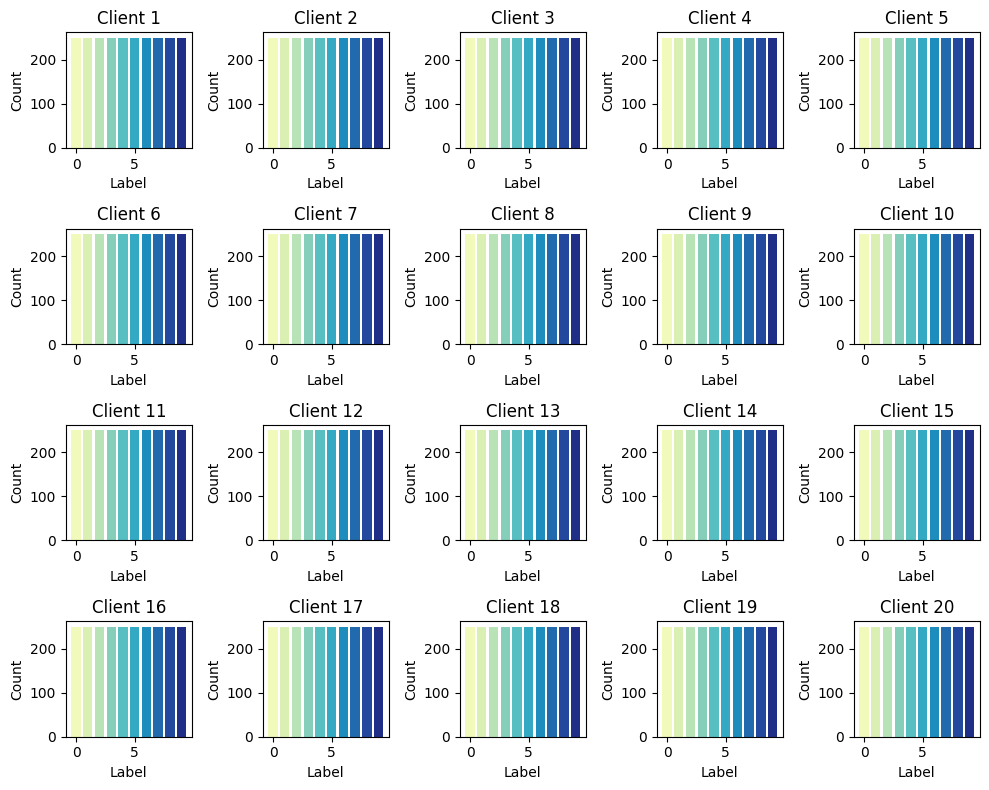

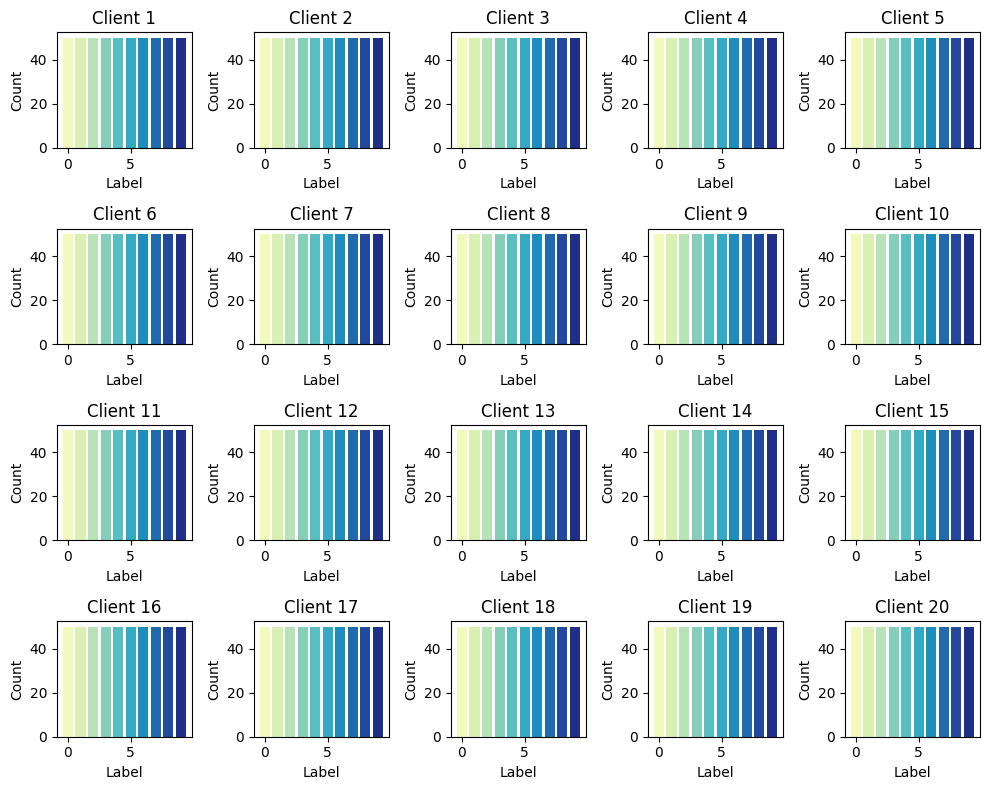

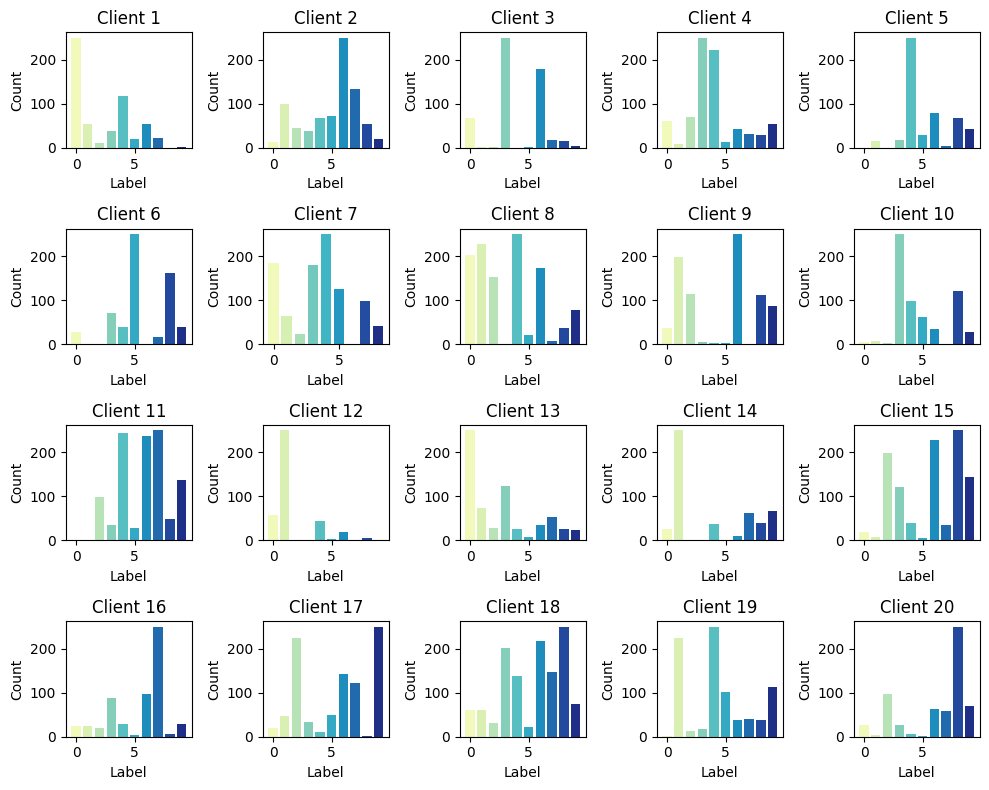

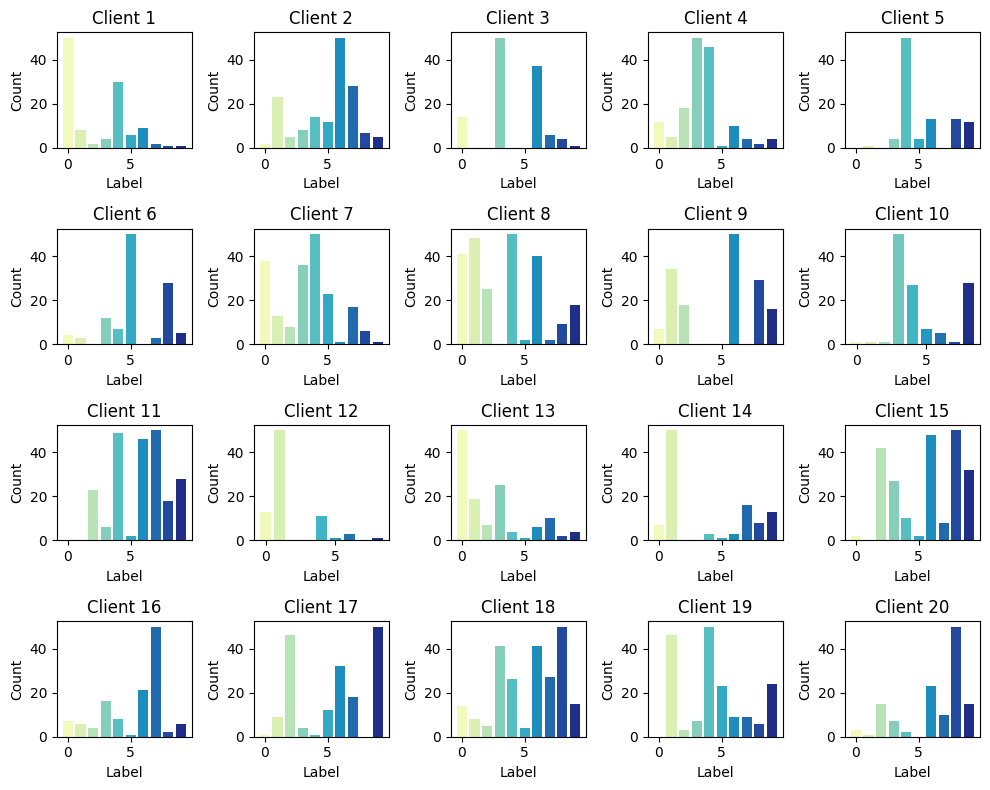

In [ ]:
train_iid_loaders, test_iid_loaders = split_dataset_balanced(NUM_CLIENTS, cifar10_trainset, cifar10_testset)

plot_label_distribution(train_iid_loaders)
plot_label_distribution(test_iid_loaders)

train_non_iid_loaders, test_non_iid_loaders = create_unbalanced_loaders(train_iid_loaders, test_iid_loaders, 10, alpha=0.5)

plot_label_distribution(train_non_iid_loaders)
plot_label_distribution(test_non_iid_loaders)

with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/train_iid_loaders.pkl', 'wb') as f:
    pickle.dump(train_iid_loaders, f)

with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/test_iid_loaders.pkl', 'wb') as f:
    pickle.dump(test_iid_loaders, f)

with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/train_non_iid_loaders.pkl', 'wb') as f:
    pickle.dump(train_non_iid_loaders, f)

with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/test_non_iid_loaders.pkl', 'wb') as f:
    pickle.dump(test_non_iid_loaders, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/train_iid_loaders.pkl', 'rb') as f:
    train_iid_loaders = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/test_iid_loaders.pkl', 'rb') as f:
    test_iid_loaders = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/train_non_iid_loaders.pkl', 'rb') as f:
    train_non_iid_loaders = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/test_non_iid_loaders.pkl', 'rb') as f:
    test_non_iid_loaders = pickle.load(f)

In [ ]:
len(train_non_iid_loaders)

20

In [ ]:
train_iid_loaders[0].dataset[0]

(tensor([[[-0.2314, -0.4118, -0.6863,  ..., -0.7647, -0.8118, -0.8118],
          [-0.1216, -0.4353, -0.6706,  ..., -0.7569, -0.7333, -0.7725],
          [-0.0745, -0.5059, -0.6471,  ..., -0.9294, -0.7725, -0.7098],
          ...,
          [ 0.1529,  0.1373,  0.1294,  ...,  0.0588,  0.0118, -0.0353],
          [ 0.1373,  0.0902,  0.0588,  ..., -0.0275, -0.0196,  0.0275],
          [ 0.0902,  0.0745,  0.0824,  ...,  0.0196,  0.0431,  0.0353]],
 
         [[-0.0588, -0.1294, -0.3961,  ..., -0.5373, -0.5843, -0.6157],
          [ 0.0824, -0.1373, -0.3804,  ..., -0.5922, -0.4902, -0.5373],
          [ 0.1373, -0.2000, -0.3490,  ..., -0.8745, -0.6078, -0.4510],
          ...,
          [ 0.4196,  0.4196,  0.4196,  ...,  0.3490,  0.3020,  0.2471],
          [ 0.4039,  0.3725,  0.3569,  ...,  0.2784,  0.2784,  0.3176],
          [ 0.3804,  0.3804,  0.3804,  ...,  0.3333,  0.3490,  0.3176]],
 
         [[-0.6157, -0.7961, -0.8902,  ..., -0.9216, -0.9137, -0.9059],
          [-0.6157, -0.8275,

In [ ]:
# Example for homogeneous optimistic case
homogeneous_optimistic_p1_p2_pairs = [(0.1, 0.9), (0.3, 0.7), (0.4, 0.6)]
homogeneous_pessimistic_p1_p2_pairs = [(0.5, 0.5), (0.6, 0.4), (0.9, 0.1)]
heterogeneous_q_values = [0.1, 0.5, 0.9]


In [ ]:
class MethodD(fl.server.strategy.FedAvg):
    def __init__(self, p, num_clients, p1=None, p2=None, q=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p  # Fraction of clients to select
        self.num_clients = num_clients

        self.index_to_cid = {}
        self.cid_to_index = {}

        self.accuracies = []
        self.losses = []
        self.accuracy_df = pd.DataFrame()

        self.selected_clients = []  # To store selected clients
        self.probability_df = pd.DataFrame()
        self.availability_df = pd.DataFrame()  # DataFrame to store availability matrix

        self.state = {f"Client {i + 1}": "ON" for i in range(num_clients)}  # state for each client (all are 'ON' at the beginning)

        # Assign p1 and p2 for homogeneous or heterogeneous cases
        if q is None:  # Homogeneous case
            self.p1_dict = {f"Client {i + 1}": p1 for i in range(num_clients)}
            self.p2_dict = {f"Client {i + 1}": p2 for i in range(num_clients)}
        else:  # Heterogeneous case
            self.p1_dict = {}
            self.p2_dict = {}
            for i in range(num_clients):
                client_key = f"Client {i + 1}"
                if np.random.rand() < q:  # Optimistic
                    self.p1_dict[client_key] = np.random.choice([0.1, 0.3, 0.4])
                    self.p2_dict[client_key] = 1 - self.p1_dict[client_key]
                else:  # Pessimistic
                    self.p1_dict[client_key] = np.random.choice([0.5, 0.6, 0.9])
                    self.p2_dict[client_key] = 1 - self.p1_dict[client_key]

        print("Initial p1 and p2 values:")
        for client in self.p1_dict.keys():
            print(f"{client}: (p1: {self.p1_dict[client]}, p2: {self.p2_dict[client]})")


    def configure_fit(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, FitIns]]:

        sample_size = int(self.p * self.num_clients)
        all_clients = client_manager.all()
        # print(f"all_clients: {all_clients}")

        first_item = next(iter(all_clients.items()))
        # print(f"first_item[1].node_id: {first_item[1].node_id}")
        # print(f"first_item[1].cid: {first_item[1].cid}")

        selected_clients_cids = [client.cid for client in self.selected_clients]
        # print(f"selected_clients_cids: {selected_clients_cids}")

        selected_clients = []
        round_probabilities = {}

        # check transition of availablity
        for index in range(self.num_clients):
            client_key = f"Client {index + 1}"
            if self.state[client_key] == "ON":
                if np.random.rand() <= self.p1_dict[client_key]:
                    self.state[client_key] = "OFF"
            elif self.state[client_key] == "OFF":
                if np.random.rand() <= self.p2_dict[client_key]:
                    self.state[client_key] = "ON"

        if(server_round == 1):
            for index, cid in enumerate(all_clients.keys()):
              self.index_to_cid[index] = cid
              self.cid_to_index[cid] = index


            # print(f"self.index_to_cid: {self.index_to_cid}")

            # Round 1: All nodes have p probability of selection
            for i in range(self.num_clients):
                client_cid = self.index_to_cid[i]
                client_key = f"Client {i + 1}"

                if np.random.rand() <= self.p and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[client_cid])

                # store round probabilities
                round_probabilities[client_key] = self.p
        else:
            # Round t: Nodes have selection probability based on accuracy from previous round
            for i in range(self.num_clients):
                client_key = f"Client {i + 1}"
                client_cid = self.index_to_cid[i]

                if client_cid in selected_clients_cids:
                    last_round_accuracy = self.accuracy_df[client_key].iloc[-1]
                    prob = np.exp(-1.5 * last_round_accuracy)
                else:
                    prob = self.probability_df[client_key].iloc[-1]

                # store round probabilities
                round_probabilities[client_key] = prob

                if np.random.rand() < prob and self.state[client_key] == "ON":
                    selected_clients.append(all_clients[client_cid])

        # Ensure at least one client is selected
        if not selected_clients:
            selected_clients.append(all_clients[self.index_to_cid[random.randint(0, self.num_clients - 1)]])

        # update selected clients
        self.selected_clients = selected_clients

        # Update probability dataframe
        prob_df = pd.DataFrame(round_probabilities, index=[server_round])
        self.probability_df = pd.concat([self.probability_df, prob_df])

        # Update availability dataframe
        availability_dict = {}
        for client_key, state in self.state.items():
            availability_dict[client_key] = 1 if state == "ON" else 0

        avail_df = pd.DataFrame(availability_dict, index=[server_round])
        self.availability_df = pd.concat([self.availability_df, avail_df])

        # finish configure_fit
        fit_ins = FitIns(parameters, {})
        # print(f"Serial number of the client selected to fit: {[self.cid_to_index[client.cid] for client in self.selected_clients]}")
        return [(client, fit_ins) for client in self.selected_clients]

    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:

        # Use only selected clients for evaluation
        evaluate_clients = self.selected_clients

        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Return client/config pairs for evaluation
        # print(f"Serial number of the client selected to evaluate: {[self.cid_to_index[client.cid] for client in evaluate_clients]}")
        return [(client, evaluate_ins) for client in evaluate_clients]

    def aggregate_evaluate(
        self,
        rnd: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.EvaluateRes]],
        failures: List[BaseException]
    ) -> Tuple[float, Dict[str, Any]]:

        # Initialize dictionaries to store evaluated client accuracy
        evaluated_client_dict = {}
        round_accuracy_dict = {}

        for client_proxy, evaluate_res in results:
            # Assume evaluate_res has an 'accuracy' attribute
            client_cid = client_proxy.cid
            accuracy = evaluate_res.metrics["accuracy"]

            evaluated_client_dict[client_cid] = accuracy

        # Generate accuracy dict for all clients
        for index in range(self.num_clients):
            client_key = f"Client {index + 1}"
            client_cid = self.index_to_cid[index]

            if client_cid in evaluated_client_dict.keys():
                round_accuracy_dict[client_key] = evaluated_client_dict[client_cid]
            else:
                if(rnd == 1):
                    round_accuracy_dict[client_key] = float('NaN')
                else:
                    round_accuracy_dict[client_key] = self.accuracy_df[client_key].iloc[-1]

        round_accuracies = [result.metrics["accuracy"] for _, result in results]
        # round_accuracy_dict = {f"Client {client_idx + 1}": accuracy for client_idx, accuracy in enumerate(round_accuracies)}

        round_df = pd.DataFrame(round_accuracy_dict, index=[rnd])
        accuracy = np.mean(round_accuracies)

        self.accuracies.append(accuracy)
        self.losses.append([result.loss for _, result in results])
        self.accuracy_df = pd.concat([self.accuracy_df, round_df])

        return super().aggregate_evaluate(rnd, results, failures)

    def plot_accuracies(self):
        plt.figure()
        plt.plot(range(1, len(self.accuracies) + 1), self.accuracies, marker='o')
        plt.title("Accuracy per Round")
        plt.xlabel("Round")
        plt.ylabel("Accuracy")
        plt.grid()
        plt.show()

    def print_accuracy_matrix(self):
        print("Classification Accuracy Matrix:")
        print(self.accuracy_df)

    def save_accuracy_matrix(self, file_path):
        self.accuracy_df.to_csv(file_path, index_label='Round')

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout


Initial p1 and p2 values:
Client 1: (p1: 0.1, p2: 0.9)
Client 2: (p1: 0.1, p2: 0.9)
Client 3: (p1: 0.1, p2: 0.9)
Client 4: (p1: 0.1, p2: 0.9)
Client 5: (p1: 0.1, p2: 0.9)
Client 6: (p1: 0.1, p2: 0.9)
Client 7: (p1: 0.1, p2: 0.9)
Client 8: (p1: 0.1, p2: 0.9)
Client 9: (p1: 0.1, p2: 0.9)
Client 10: (p1: 0.1, p2: 0.9)
Client 11: (p1: 0.1, p2: 0.9)
Client 12: (p1: 0.1, p2: 0.9)
Client 13: (p1: 0.1, p2: 0.9)
Client 14: (p1: 0.1, p2: 0.9)
Client 15: (p1: 0.1, p2: 0.9)
Client 16: (p1: 0.1, p2: 0.9)
Client 17: (p1: 0.1, p2: 0.9)
Client 18: (p1: 0.1, p2: 0.9)
Client 19: (p1: 0.1, p2: 0.9)
Client 20: (p1: 0.1, p2: 0.9)


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-05 01:09:28,402	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'memory': 7983511143.0, 'object_store_memory': 3991755571.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=16544) 2024-08-05 01:09:33.028958: E external/l

Initial p1 and p2 values:
Client 1: (p1: 0.3, p2: 0.7)
Client 2: (p1: 0.3, p2: 0.7)
Client 3: (p1: 0.3, p2: 0.7)
Client 4: (p1: 0.3, p2: 0.7)
Client 5: (p1: 0.3, p2: 0.7)
Client 6: (p1: 0.3, p2: 0.7)
Client 7: (p1: 0.3, p2: 0.7)
Client 8: (p1: 0.3, p2: 0.7)
Client 9: (p1: 0.3, p2: 0.7)
Client 10: (p1: 0.3, p2: 0.7)
Client 11: (p1: 0.3, p2: 0.7)
Client 12: (p1: 0.3, p2: 0.7)
Client 13: (p1: 0.3, p2: 0.7)
Client 14: (p1: 0.3, p2: 0.7)
Client 15: (p1: 0.3, p2: 0.7)
Client 16: (p1: 0.3, p2: 0.7)
Client 17: (p1: 0.3, p2: 0.7)
Client 18: (p1: 0.3, p2: 0.7)
Client 19: (p1: 0.3, p2: 0.7)
Client 20: (p1: 0.3, p2: 0.7)


(pid=16546) 2024-08-05 01:09:33.201655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=16546) 2024-08-05 01:09:33.244783: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=16546) 2024-08-05 01:09:33.256905: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=16546) 2024-08-05 01:09:36.986780: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

Initial p1 and p2 values:
Client 1: (p1: 0.4, p2: 0.6)
Client 2: (p1: 0.4, p2: 0.6)
Client 3: (p1: 0.4, p2: 0.6)
Client 4: (p1: 0.4, p2: 0.6)
Client 5: (p1: 0.4, p2: 0.6)
Client 6: (p1: 0.4, p2: 0.6)
Client 7: (p1: 0.4, p2: 0.6)
Client 8: (p1: 0.4, p2: 0.6)
Client 9: (p1: 0.4, p2: 0.6)
Client 10: (p1: 0.4, p2: 0.6)
Client 11: (p1: 0.4, p2: 0.6)
Client 12: (p1: 0.4, p2: 0.6)
Client 13: (p1: 0.4, p2: 0.6)
Client 14: (p1: 0.4, p2: 0.6)
Client 15: (p1: 0.4, p2: 0.6)
Client 16: (p1: 0.4, p2: 0.6)
Client 17: (p1: 0.4, p2: 0.6)
Client 18: (p1: 0.4, p2: 0.6)
Client 19: (p1: 0.4, p2: 0.6)
Client 20: (p1: 0.4, p2: 0.6)


(pid=35661) 2024-08-05 01:33:16.899368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=35661) 2024-08-05 01:33:16.958862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=35661) 2024-08-05 01:33:16.981125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=35661) 2024-08-05 01:33:19.708845: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

Initial p1 and p2 values:
Client 1: (p1: 0.5, p2: 0.5)
Client 2: (p1: 0.5, p2: 0.5)
Client 3: (p1: 0.5, p2: 0.5)
Client 4: (p1: 0.5, p2: 0.5)
Client 5: (p1: 0.5, p2: 0.5)
Client 6: (p1: 0.5, p2: 0.5)
Client 7: (p1: 0.5, p2: 0.5)
Client 8: (p1: 0.5, p2: 0.5)
Client 9: (p1: 0.5, p2: 0.5)
Client 10: (p1: 0.5, p2: 0.5)
Client 11: (p1: 0.5, p2: 0.5)
Client 12: (p1: 0.5, p2: 0.5)
Client 13: (p1: 0.5, p2: 0.5)
Client 14: (p1: 0.5, p2: 0.5)
Client 15: (p1: 0.5, p2: 0.5)
Client 16: (p1: 0.5, p2: 0.5)
Client 17: (p1: 0.5, p2: 0.5)
Client 18: (p1: 0.5, p2: 0.5)
Client 19: (p1: 0.5, p2: 0.5)
Client 20: (p1: 0.5, p2: 0.5)


(pid=51188) 2024-08-05 01:52:54.098149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=51188) 2024-08-05 01:52:54.140270: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=51188) 2024-08-05 01:52:54.152747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=51188) 2024-08-05 01:52:57.190418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

Initial p1 and p2 values:
Client 1: (p1: 0.6, p2: 0.4)
Client 2: (p1: 0.6, p2: 0.4)
Client 3: (p1: 0.6, p2: 0.4)
Client 4: (p1: 0.6, p2: 0.4)
Client 5: (p1: 0.6, p2: 0.4)
Client 6: (p1: 0.6, p2: 0.4)
Client 7: (p1: 0.6, p2: 0.4)
Client 8: (p1: 0.6, p2: 0.4)
Client 9: (p1: 0.6, p2: 0.4)
Client 10: (p1: 0.6, p2: 0.4)
Client 11: (p1: 0.6, p2: 0.4)
Client 12: (p1: 0.6, p2: 0.4)
Client 13: (p1: 0.6, p2: 0.4)
Client 14: (p1: 0.6, p2: 0.4)
Client 15: (p1: 0.6, p2: 0.4)
Client 16: (p1: 0.6, p2: 0.4)
Client 17: (p1: 0.6, p2: 0.4)
Client 18: (p1: 0.6, p2: 0.4)
Client 19: (p1: 0.6, p2: 0.4)
Client 20: (p1: 0.6, p2: 0.4)


(pid=65738) 2024-08-05 02:11:23.356233: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=65738) 2024-08-05 02:11:23.629349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=65738) 2024-08-05 02:11:23.680519: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=65739) 2024-08-05 02:11:26.634746: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

Initial p1 and p2 values:
Client 1: (p1: 0.9, p2: 0.1)
Client 2: (p1: 0.9, p2: 0.1)
Client 3: (p1: 0.9, p2: 0.1)
Client 4: (p1: 0.9, p2: 0.1)
Client 5: (p1: 0.9, p2: 0.1)
Client 6: (p1: 0.9, p2: 0.1)
Client 7: (p1: 0.9, p2: 0.1)
Client 8: (p1: 0.9, p2: 0.1)
Client 9: (p1: 0.9, p2: 0.1)
Client 10: (p1: 0.9, p2: 0.1)
Client 11: (p1: 0.9, p2: 0.1)
Client 12: (p1: 0.9, p2: 0.1)
Client 13: (p1: 0.9, p2: 0.1)
Client 14: (p1: 0.9, p2: 0.1)
Client 15: (p1: 0.9, p2: 0.1)
Client 16: (p1: 0.9, p2: 0.1)
Client 17: (p1: 0.9, p2: 0.1)
Client 18: (p1: 0.9, p2: 0.1)
Client 19: (p1: 0.9, p2: 0.1)
Client 20: (p1: 0.9, p2: 0.1)


(pid=77201) 2024-08-05 02:26:37.151204: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-05 02:40:27,388	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 8013697844.0, 'object_store_memory': 4006848921.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors


Initial p1 and p2 values:
Client 1: (p1: 0.5, p2: 0.5)
Client 2: (p1: 0.9, p2: 0.09999999999999998)
Client 3: (p1: 0.5, p2: 0.5)
Client 4: (p1: 0.9, p2: 0.09999999999999998)
Client 5: (p1: 0.3, p2: 0.7)
Client 6: (p1: 0.9, p2: 0.09999999999999998)
Client 7: (p1: 0.9, p2: 0.09999999999999998)
Client 8: (p1: 0.1, p2: 0.9)
Client 9: (p1: 0.6, p2: 0.4)
Client 10: (p1: 0.5, p2: 0.5)
Client 11: (p1: 0.6, p2: 0.4)
Client 12: (p1: 0.5, p2: 0.5)
Client 13: (p1: 0.5, p2: 0.5)
Client 14: (p1: 0.9, p2: 0.09999999999999998)
Client 15: (p1: 0.4, p2: 0.6)
Client 16: (p1: 0.4, p2: 0.6)
Client 17: (p1: 0.5, p2: 0.5)
Client 18: (p1: 0.6, p2: 0.4)
Client 19: (p1: 0.6, p2: 0.4)
Client 20: (p1: 0.9, p2: 0.09999999999999998)


(pid=87203) 2024-08-05 02:40:40.824627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=87203) 2024-08-05 02:40:40.952286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=87203) 2024-08-05 02:40:40.997082: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(pid=87203) 2024-08-05 02:40:44.311421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock

Initial p1 and p2 values:
Client 1: (p1: 0.9, p2: 0.09999999999999998)
Client 2: (p1: 0.9, p2: 0.09999999999999998)
Client 3: (p1: 0.5, p2: 0.5)
Client 4: (p1: 0.5, p2: 0.5)
Client 5: (p1: 0.9, p2: 0.09999999999999998)
Client 6: (p1: 0.1, p2: 0.9)
Client 7: (p1: 0.5, p2: 0.5)
Client 8: (p1: 0.9, p2: 0.09999999999999998)
Client 9: (p1: 0.1, p2: 0.9)
Client 10: (p1: 0.3, p2: 0.7)
Client 11: (p1: 0.1, p2: 0.9)
Client 12: (p1: 0.4, p2: 0.6)
Client 13: (p1: 0.4, p2: 0.6)
Client 14: (p1: 0.3, p2: 0.7)
Client 15: (p1: 0.4, p2: 0.6)
Client 16: (p1: 0.1, p2: 0.9)
Client 17: (p1: 0.9, p2: 0.09999999999999998)
Client 18: (p1: 0.9, p2: 0.09999999999999998)
Client 19: (p1: 0.6, p2: 0.4)
Client 20: (p1: 0.6, p2: 0.4)


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-05 03:04:22,368	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'memory': 8008853915.0, 'object_store_memory': 4004426956.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=102205) 2024-08-05 03:04:27.180112: E external/

Initial p1 and p2 values:
Client 1: (p1: 0.3, p2: 0.7)
Client 2: (p1: 0.3, p2: 0.7)
Client 3: (p1: 0.3, p2: 0.7)
Client 4: (p1: 0.4, p2: 0.6)
Client 5: (p1: 0.1, p2: 0.9)
Client 6: (p1: 0.1, p2: 0.9)
Client 7: (p1: 0.1, p2: 0.9)
Client 8: (p1: 0.4, p2: 0.6)
Client 9: (p1: 0.3, p2: 0.7)
Client 10: (p1: 0.1, p2: 0.9)
Client 11: (p1: 0.6, p2: 0.4)
Client 12: (p1: 0.3, p2: 0.7)
Client 13: (p1: 0.9, p2: 0.09999999999999998)
Client 14: (p1: 0.4, p2: 0.6)
Client 15: (p1: 0.3, p2: 0.7)
Client 16: (p1: 0.1, p2: 0.9)
Client 17: (p1: 0.1, p2: 0.9)
Client 18: (p1: 0.3, p2: 0.7)
Client 19: (p1: 0.3, p2: 0.7)
Client 20: (p1: 0.1, p2: 0.9)


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-05 03:20:28,848	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'memory': 8008645019.0, 'object_store_memory': 4004322508.0, 'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=114284) 2024-08-05 03:20:35.726051: E external/

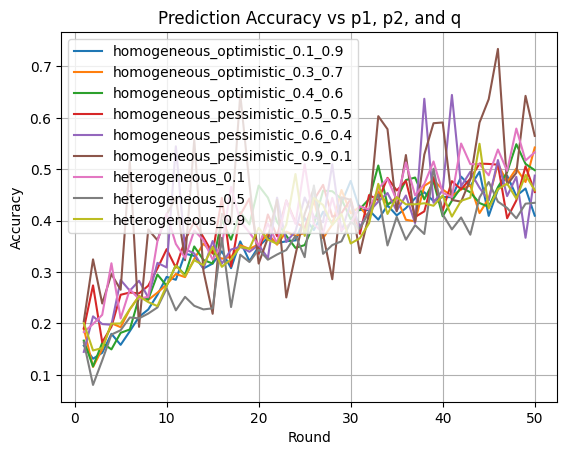

In [16]:
# Example for homogeneous optimistic case
homogeneous_optimistic_p1_p2_pairs = [(0.1, 0.9), (0.3, 0.7), (0.4, 0.6)]
homogeneous_pessimistic_p1_p2_pairs = [(0.5, 0.5), (0.6, 0.4), (0.9, 0.1)]
heterogeneous_q_values = [0.1, 0.5, 0.9]

results = {}

# Homogeneous optimistic
for p1, p2 in homogeneous_optimistic_p1_p2_pairs:
    strategy = MethodD(p=0.5, num_clients=NUM_CLIENTS, p1=p1, p2=p2, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), cifar10_testloader))
    start_simulation(train_non_iid_loaders, test_non_iid_loaders, strategy)
    results[f'homogeneous_optimistic_{p1}_{p2}'] = strategy.accuracies
    strategy.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/accuracy_matrix_p1={p1}_p2={p2}.csv')
    strategy.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/probability_matrix_p1={p1}_p2={p2}.csv')
    strategy.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/availability_matrix_p1={p1}_p2={p2}.csv')

# Homogeneous pessimistic
for p1, p2 in homogeneous_pessimistic_p1_p2_pairs:
    strategy = MethodD(p=0.5, num_clients=NUM_CLIENTS, p1=p1, p2=p2, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), cifar10_testloader))
    start_simulation(train_non_iid_loaders, test_non_iid_loaders, strategy)
    results[f'homogeneous_pessimistic_{p1}_{p2}'] = strategy.accuracies
    strategy.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/accuracy_matrix_p1={p1}_p2={p2}.csv')
    strategy.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/probability_matrix_p1={p1}_p2={p2}.csv')
    strategy.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/availability_matrix_p1={p1}_p2={p2}.csv')

# Heterogeneous
for q in heterogeneous_q_values:
    strategy = MethodD(p=0.5, num_clients=NUM_CLIENTS, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), cifar10_testloader), q=q)
    start_simulation(train_non_iid_loaders, test_non_iid_loaders, strategy)
    results[f'heterogeneous_{q}'] = strategy.accuracies
    strategy.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/accuracy_matrix_q={q}.csv')
    strategy.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/probability_matrix_q={q}.csv')
    strategy.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/availability_matrix_q={q}.csv')

# Plot results
for key, accuracies in results.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, label=key)

plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Prediction Accuracy vs p1, p2, and q')
plt.legend()
plt.grid()
plt.show()

INFO :      Starting Flower simulation, config: num_rounds=3, no round_timeout


Initial p1 and p2 values:
Client 1: (p1: 0.1, p2: 0.9)
Client 2: (p1: 0.1, p2: 0.9)
Client 3: (p1: 0.1, p2: 0.9)
Client 4: (p1: 0.1, p2: 0.9)
Client 5: (p1: 0.1, p2: 0.9)
Client 6: (p1: 0.1, p2: 0.9)
Client 7: (p1: 0.1, p2: 0.9)
Client 8: (p1: 0.1, p2: 0.9)
Client 9: (p1: 0.1, p2: 0.9)
Client 10: (p1: 0.1, p2: 0.9)
Client 11: (p1: 0.1, p2: 0.9)
Client 12: (p1: 0.1, p2: 0.9)
Client 13: (p1: 0.1, p2: 0.9)
Client 14: (p1: 0.1, p2: 0.9)
Client 15: (p1: 0.1, p2: 0.9)
Client 16: (p1: 0.1, p2: 0.9)
Client 17: (p1: 0.1, p2: 0.9)
Client 18: (p1: 0.1, p2: 0.9)
Client 19: (p1: 0.1, p2: 0.9)
Client 20: (p1: 0.1, p2: 0.9)


/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-08-04 00:39:40,034	INFO worker.py:1752 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:172.28.0.12': 1.0, 'node:__internal_head__': 1.0, 'memory': 7995428046.0, 'object_store_memory': 3997714022.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      No `client_resources` specified. Using minimal resources for clients.
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0.0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=41509) 2024-08-04 00:39:46.917836: E external/l

all_clients: {'-3060372456307046550': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7c9d0>, '-8667327527024410958': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7ca30>, '-1199749141439827250': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7ce50>, '-5413907301156596424': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7d210>, '-4755541630199022734': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7cee0>, '-2184895437825850456': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7fe80>, '-8880186944245266719': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7fa90>, '-4757384942057525990': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7f940>, '-9102480236998834644': <flwr.simu

INFO :      aggregate_fit: received 9 results and 0 failures
INFO :      fit progress: (1, 720.0600929260254, {'accuracy': 0.1021}, 69.57091359900005)
INFO :      configure_evaluate: strategy sampled 9 clients (out of 20)


Serial number of the client selected to evaluate: [0, 1, 2, 5, 7, 10, 11, 16, 19]


INFO :      aggregate_evaluate: received 9 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 11 clients (out of 20)


all_clients: {'-3060372456307046550': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7c9d0>, '-8667327527024410958': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7ca30>, '-1199749141439827250': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7ce50>, '-5413907301156596424': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7d210>, '-4755541630199022734': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7cee0>, '-2184895437825850456': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7fe80>, '-8880186944245266719': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7fa90>, '-4757384942057525990': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7f940>, '-9102480236998834644': <flwr.simu

INFO :      aggregate_fit: received 11 results and 0 failures
INFO :      fit progress: (2, 718.4914107322693, {'accuracy': 0.143}, 151.38612505700075)
INFO :      configure_evaluate: strategy sampled 11 clients (out of 20)


Serial number of the client selected to evaluate: [0, 1, 2, 3, 7, 10, 11, 12, 13, 16, 19]


INFO :      aggregate_evaluate: received 11 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 14 clients (out of 20)


all_clients: {'-3060372456307046550': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7c9d0>, '-8667327527024410958': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7ca30>, '-1199749141439827250': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7ce50>, '-5413907301156596424': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7d210>, '-4755541630199022734': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7cee0>, '-2184895437825850456': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7fe80>, '-8880186944245266719': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7fa90>, '-4757384942057525990': <flwr.simulation.ray_transport.ray_client_proxy.RayActorClientProxy object at 0x7b2ab8b7f940>, '-9102480236998834644': <flwr.simu

INFO :      aggregate_fit: received 14 results and 0 failures
INFO :      fit progress: (3, 712.7181806564331, {'accuracy': 0.2024}, 251.43353610600025)
INFO :      configure_evaluate: strategy sampled 14 clients (out of 20)


Serial number of the client selected to evaluate: [0, 1, 3, 5, 6, 7, 10, 11, 12, 13, 15, 16, 17, 19]


INFO :      aggregate_evaluate: received 14 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 255.28s
INFO :      	History (loss, distributed):
INFO :      		round 1: 36.80744290351868
INFO :      		round 2: 36.729643539948896
INFO :      		round 3: 36.43597575596401
INFO :      	History (loss, centralized):
INFO :      		round 0: 720.891578912735
INFO :      		round 1: 720.0600929260254
INFO :      		round 2: 718.4914107322693
INFO :      		round 3: 712.7181806564331
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.1), (1, 0.1021), (2, 0.143), (3, 0.2024)]}
INFO :      


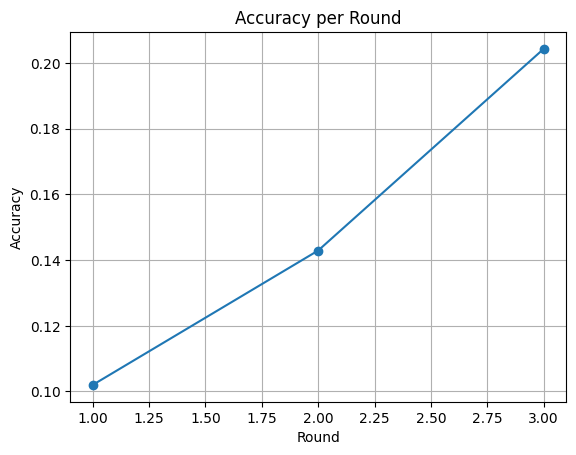

Classification Accuracy Matrix:
   Client 1  Client 2  Client 3  Client 4  Client 5  Client 6  Client 7  \
1     0.104     0.108     0.102       NaN       NaN     0.102       NaN   
2     0.156     0.154     0.142     0.138       NaN     0.102       NaN   
3     0.228     0.202     0.142     0.178       NaN     0.204     0.256   

   Client 8  Client 9  Client 10  Client 11  Client 12  Client 13  Client 14  \
1     0.102       NaN        NaN      0.098      0.098        NaN        NaN   
2     0.128       NaN        NaN      0.146      0.136      0.150      0.136   
3     0.196       NaN        NaN      0.196      0.198      0.198      0.200   

   Client 15  Client 16  Client 17  Client 18  Client 19  Client 20  
1        NaN        NaN      0.100        NaN        NaN      0.104  
2        NaN        NaN      0.142        NaN        NaN      0.144  
3        NaN      0.204      0.194      0.212        NaN      0.194  


In [ ]:
CIFAR_10_iid_strategy_D = MethodD(0.5, NUM_CLIENTS, p1=0.1, p2=0.9, evaluate_fn=get_evaluate_server_fn(Net().to(DEVICE), cifar10_testloader))

start_simulation(train_iid_loaders, test_iid_loaders, CIFAR_10_iid_strategy_D)
CIFAR_10_iid_strategy_D.save_accuracy_matrix(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/iid_strategy_D_accuracy_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_iid_strategy_D.probability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/iid_strategy_D_probability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')
CIFAR_10_iid_strategy_D.availability_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/graduation project/Week8/cifar10/iid_strategy_D_availability_matrix_clients={NUM_CLIENTS}_round={ROUND}.csv')

